In [1]:
%matplotlib inline
import skyflux as sf

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
nside = 128

theta, phi = hp.pix2ang(nside,np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
#J = sf.stokes.spline_beam_func(151e6, alt, az)

# Not 100% sure about this LST arg
J = sf.stokes.create_J(az=az, alt=alt, lst=0, nu=151e6, radians=True)
J_abs = np.abs(J)

In [4]:
print('HERA latitude:', sf.rot.hera_lat)
print('HERA longitude:', sf.rot.hera_lon)
print('Current LST:', sf.rot.get_lst(radians=False))

HERA latitude: -30.72138888888889
HERA longitude: 21.428333333333335
Current LST: 33.534131378487146


In [5]:
# I do not remember what the point of this cell is -> marked for deletion.

lst_now_deg = np.degrees(sf.rot.get_lst(radians=False))
az, alt = sf.rot.eq_to_topo(lst_now_deg, sf.rot.hera_lat, sf.rot.hera_lat, lst_now_deg, radians=False)
print('With right ascension = LST and declination = HERA latitude, we have:')
print('Azimuth:', az, 'altitude:', alt)
# the azimuth is going to land all over the place, but it is okay:
# because we are working at zenith, azimuth becomes meaningless

With right ascension = LST and declination = HERA latitude, we have:
Azimuth: 0.0 altitude: 90.0


In [6]:
def rad_interp(J_section, az, alt):
    """
    Abbreviation and conversion function. We get the interpolation value
    assuming @az and @alt are in degrees.
    """
    colatitude = np.radians(90 - alt)
    longitude = np.radians(az)
    return hp.get_interp_val(J_section, colatitude, longitude)

In [7]:
# :: xy and yx are just leakage terms; they are not beam response terms
# in other words, the maximum response can occur at any point, and it is okay that these do not maximize.

print(rad_interp(J_abs[:, 1, 0], az, alt)) # true maximum: .998166
print(rad_interp(J_abs[:, 0, 0], az, alt)) # ": .0624716
print(rad_interp(J_abs[:, 0, 1], az, alt)) # ": .998166
print(rad_interp(J_abs[:, 1, 1], az, alt)) # ": .0624716

0.002679082068575245
0.9979757403371554
0.0026280479469714124
0.9979758688492126


In [8]:
az_neigh = np.linspace(az - 20, az + 20, 1000)
az_const = np.full(1000, az)

alt_neigh = np.linspace(alt - 20, alt + 20, 1000)
alt_const = np.full(1000, alt)

In [9]:
def response_plot(label, section):
    fig, ax = sf.demo.frame() # this is somewhat abstruse;
        # maybe we should move the method to a different module. We should at least rename.
    plt.title(label + ' varying altitude about ' + str(round(alt, 1)) + '$^\circ$')
    ax.plot(alt_neigh, rad_interp(section, az_const, alt_neigh))
    plt.ylabel('Response [0, 1]', fontsize=12)
    plt.xlabel('Altitude [$^\circ$]')
    plt.show()
    
    fig, ax = sf.demo.frame()
    plt.title(label + ' varying azimuth about ' + str(round(az, 1)) + '$^\circ$')
    ax.plot(az_neigh, rad_interp(section, az_neigh, alt_const))
    plt.ylabel('Response [0, 1]', fontsize=12)
    # I have to force this y window if I want the axis to look reasonable.
    plt.ylim((0, 1.1))
    plt.xlabel('Azimuth [$^\circ$]')
    plt.show()

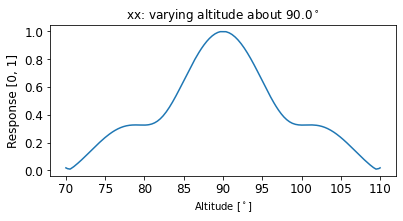

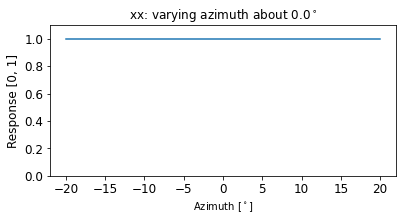

In [10]:
# The lower plot shows that azimuth has no impact near zenith.
response_plot('xx:', J_abs[:, 0, 0])

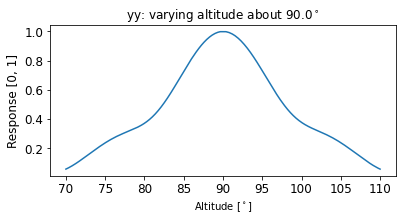

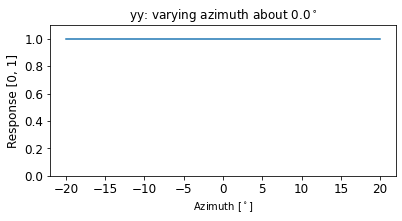

In [11]:
# Close, but not identical to the xx
response_plot('yy:', J_abs[:, 1, 1])

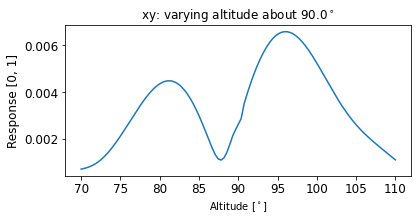

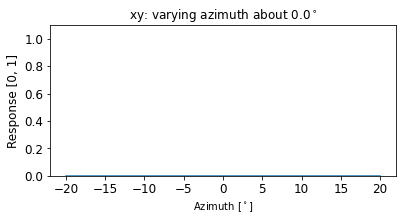

In [12]:
# Not particularly relevant (these are leakage plots), but interesting
response_plot('xy:', J_abs[:, 0, 1])

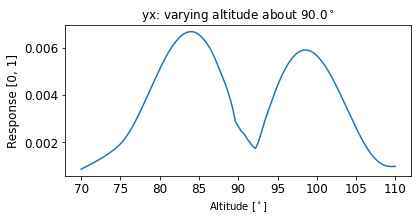

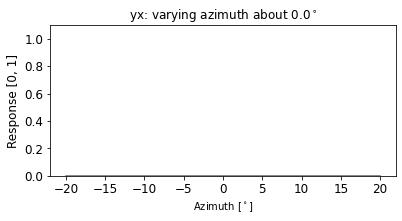

In [13]:
# Not particularly relevant (these are leakage plots), but interesting
response_plot('yx:', J_abs[:, 1, 0])